# MadMiner particle physics tutorial

# Part 3a: Training a likelihood ratio estimator

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 3a of this tutorial we will finally train a neural network to estimate likelihood ratios. We assume that you have run part 1 and 2a of this tutorial. If, instead of 2a, you have run part 2b, you just have to load a different filename later.

## Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

In [3]:
from madminer import SampleAugmenter, sampling, ParameterizedRatioEstimator

16:14 madminer             INFO    
16:14 madminer             INFO    ------------------------------------------------------------------------
16:14 madminer             INFO    |                                                                      |
16:14 madminer             INFO    |  MadMiner v0.7.4                                                     |
16:14 madminer             INFO    |                                                                      |
16:14 madminer             INFO    |         Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer  |
16:14 madminer             INFO    |                                                                      |
16:14 madminer             INFO    ------------------------------------------------------------------------
16:14 madminer             INFO    


## 1. Make (unweighted) training and test samples with augmented data

At this point, we have all the information we need from the simulations. But the data is not quite ready to be used for machine learning. The `madminer.sampling` class `SampleAugmenter` will take care of the remaining book-keeping steps before we can train our estimators:

First, it unweights the samples, i.e. for a given parameter vector `theta` (or a distribution `p(theta)`) it picks events `x` such that their distribution follows `p(x|theta)`. The selected samples will all come from the event file we have so far, but their frequency is changed -- some events will appear multiple times, some will disappear.

Second, `SampleAugmenter` calculates all the augmented data ("gold") that is the key to our new inference methods. Depending on the specific technique, these are the joint likelihood ratio and / or the joint score. It saves all these pieces of information for the selected events in a set of numpy files that can easily be used in any machine learning framework.

In [5]:
sampler = SampleAugmenter('data/lhe_data_shuffled.h5')
# sampler = SampleAugmenter('data/delphes_data_shuffled.h5')

16:16 madminer.analysis.da INFO    Loading data from data/lhe_data_shuffled.h5
16:16 madminer.analysis.da INFO    Found 1 parameters
16:16 madminer.analysis.da INFO    Did not find nuisance parameters
16:16 madminer.analysis.da INFO    Found 10 benchmarks, of which 10 physical
16:16 madminer.analysis.da INFO    Found 9 observables
16:16 madminer.analysis.da INFO    Found 6000000 events
16:16 madminer.analysis.da INFO      3000000 signal events sampled from benchmark sm
16:16 madminer.analysis.da INFO      500000 signal events sampled from benchmark 50
16:16 madminer.analysis.da INFO      500000 signal events sampled from benchmark 200
16:16 madminer.analysis.da INFO      500000 signal events sampled from benchmark 500
16:16 madminer.analysis.da INFO      500000 signal events sampled from benchmark neg_50
16:16 madminer.analysis.da INFO      500000 signal events sampled from benchmark neg_200
16:16 madminer.analysis.da INFO      500000 signal events sampled from benchmark neg_500
16:16 

The `SampleAugmenter` class defines five different high-level functions to generate train or test samples:
- `sample_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `sample_train_local()` for methods like SALLY and SALLINO, which will be demonstrated in the second part of the tutorial;
- `sample_train_density()` for neural density estimation techniques like MAF or SCANDAL;
- `sample_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL, when only theta0 is parameterized;
- `sample_train_more_ratios()` for the same techniques, but with both theta0 and theta1 parameterized;
- `sample_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can (and should!) use the helper functions `benchmark()`, `benchmarks()`, `morphing_point()`, `morphing_points()`, and `random_morphing_points()`, all defined in the `madminer.sampling` module.

Here we'll train a likelihood ratio estimator with the ALICES method, so we focus on the `extract_samples_train_ratio()` function. We'll sample the numerator hypothesis in the likelihood ratio with 1000 points drawn from a Gaussian prior, and fix the denominator hypothesis to the SM.

Note the keyword `sample_only_from_closest_benchmark=True`, which makes sure that for each parameter point we only use the events that were originally (in MG) generated from the closest benchmark. This reduces the statistical fluctuations in the outcome quite a bit.

In [6]:
x, theta0, theta1, y, r_xz, t_xz, n_effective = sampler.sample_train_ratio(
    theta0=sampling.benchmarks(['sm', '50', 'neg_50', '200', 'neg_200', '500', 'neg_500']),
    theta1=sampling.benchmark('sm'),
    n_samples=500000,
    folder='./data/samples',
    filename='train_ratio',
    sample_only_from_closest_benchmark=True,
    return_individual_n_effective=True,
)

16:16 madminer.sampling.sa INFO    Extracting training sample for ratio-based methods. Numerator hypothesis: 7 benchmarks, starting with ['sm', '50', 'neg_50'], denominator hypothesis: sm
16:16 madminer.sampling.sa INFO    Starting sampling serially
16:16 madminer.sampling.sa INFO    Sampling from parameter point 1 / 7
16:16 madminer.sampling.sa INFO    Sampling from parameter point 2 / 7
16:16 madminer.sampling.sa INFO    Sampling from parameter point 3 / 7
16:16 madminer.sampling.sa INFO    Sampling from parameter point 4 / 7
16:16 madminer.sampling.sa INFO    Sampling from parameter point 5 / 7
16:16 madminer.sampling.sa INFO    Sampling from parameter point 6 / 7
16:16 madminer.sampling.sa INFO    Sampling from parameter point 7 / 7
16:16 madminer.sampling.sa INFO    Effective number of samples: mean 514285.71428571426, with individual thetas ranging from 299754.0 to 1800699.9999999998
16:16 madminer.sampling.sa INFO    Starting sampling serially
16:16 madminer.sampling.sa INFO    

For the evaluation we'll need a test sample:

In [7]:
_ = sampler.sample_test(
    theta=sampling.benchmark('sm'),
    n_samples=1000,
    folder='./data/samples',
    filename='test'
)

16:16 madminer.sampling.sa INFO    Extracting evaluation sample. Sampling according to sm
16:16 madminer.sampling.sa INFO    Starting sampling serially
16:16 madminer.sampling.sa INFO    Sampling from parameter point 1 / 1
16:16 madminer.sampling.sa INFO    Effective number of samples: mean 599782.0, with individual thetas ranging from 599782.0 to 599782.0


In [8]:
_,_,neff=sampler.sample_train_plain(
    #theta=sampling.morphing_point([0,0.5]),
    theta=sampling.benchmarks(['50', 'neg_50', '200', 'neg_200', '500', 'neg_500']),
    n_samples=10000,
)

16:16 madminer.sampling.sa INFO    Extracting plain training sample. Sampling according to 6 benchmarks, starting with ['50', 'neg_50', '200']
16:16 madminer.sampling.sa INFO    Starting sampling serially
16:16 madminer.sampling.sa INFO    Sampling from parameter point 1 / 6
16:16 madminer.sampling.sa INFO    Sampling from parameter point 2 / 6
16:16 madminer.sampling.sa INFO    Sampling from parameter point 3 / 6
16:16 madminer.sampling.sa INFO    Sampling from parameter point 4 / 6
16:16 madminer.sampling.sa INFO    Sampling from parameter point 5 / 6
16:16 madminer.sampling.sa INFO    Sampling from parameter point 6 / 6
16:16 madminer.sampling.sa INFO    Effective number of samples: mean 299883.3333333333, with individual thetas ranging from 299754.0 to 300070.0


You might notice the information about the "eeffective number of samples" in the output. This is defined as `1 / max_events(weights)`; the smaller it is, the bigger the statistical fluctuations from too large weights. Let's plot this over the parameter space:

In [38]:
cmin, cmax = 10., 10000.

cut = (y.flatten()==0)

fig = plt.figure(figsize=(5,4))

sc = plt.scatter(theta0[cut][:,0], theta0[cut][:,1], c=n_effective[cut],
                 s=30., cmap='viridis',
                 norm=matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax),
                 marker='o')

cb = plt.colorbar(sc)
cb.set_label('Effective number of samples')

plt.xlim(-1.0,1.0)
plt.ylim(-1.0,1.0)
plt.tight_layout()
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 360x288 with 0 Axes>

## 2. Plot cross section over parameter space

This is not strictly necessary, but we can also plot the cross section as a function of parameter space:

In [8]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = sampler.cross_sections(
    theta=sampling.benchmarks(list(sampler.benchmarks.keys()))
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = sampler.cross_sections(
    theta=sampling.random_morphing_points(1000, [('gaussian', 0., 1.), ('gaussian', 0., 1.)])
)

09:15 madminer.sampling.sa INFO    Starting cross-section calculation
09:15 madminer.sampling.sa INFO    Starting cross-section calculation


KeyboardInterrupt: 

IndexError: index 1 is out of bounds for axis 1 with size 1

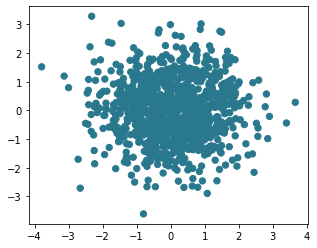

In [23]:
cmin, cmax = 0., 2.5 * np.mean(xsecs_morphing)

fig = plt.figure(figsize=(5,4))

sc = plt.scatter(thetas_morphing[:,0], thetas_morphing[:,1], c=xsecs_morphing,
            s=40., cmap='viridis', vmin=cmin, vmax=cmax,
            marker='o')

plt.scatter(thetas_benchmarks[:,0], thetas_benchmarks[:,1], c=xsecs_benchmarks,
            s=200., cmap='viridis', vmin=cmin, vmax=cmax, lw=2., edgecolor='black',
            marker='s')

cb = plt.colorbar(sc)
cb.set_label('xsec [pb]')

plt.xlim(-3.,3.)
plt.ylim(-3.,3.)
plt.tight_layout()
plt.show()

What  you see here is a morphing algorithm in action. We only asked MadGraph to calculate event weights (differential cross sections, or basically squared matrix elements) at six fixed parameter points (shown here as squares with black edges). But with our knowledge about the structure of the process we can interpolate any observable to any parameter point without loss (except that statistical uncertainties might increase)!

## 3. Train likelihood ratio estimator

It's now time to build the neural network that estimates the likelihood ratio. The central object for this is the `madminer.ml.ParameterizedRatioEstimator` class. It defines functions that train, save, load, and evaluate the estimators.

In the initialization, the keywords `n_hidden` and `activation` define the architecture of the (fully connected) neural network:

In [9]:
from madminer.ml.morphing_aware import MorphingAwareRatioEstimator

In [9]:
#estimator = ParameterizedRatioEstimator(
estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename='data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

14:11 madminer.ml.morphing INFO    Setting up morphing-aware ratio estimator with 3 morphing components


To train this model we will minimize the ALICES loss function described in ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973). Many alternatives, including RASCAL, are described in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). There is also SCANDAL introduced in ["Mining gold from implicit models to improve likelihood-free inference"](https://arxiv.org/abs/1805.12244).

In [10]:
estimator.train(
    method='carl',
    theta='data/samples/theta0_train_ratio.npy',
    x='data/samples/x_train_ratio.npy',
    y='data/samples/y_train_ratio.npy',
    r_xz='data/samples/r_xz_train_ratio.npy',
    t_xz='data/samples/t_xz_train_ratio.npy',
    alpha=10,
    n_epochs=1000,
    #scale_parameters=True,
)

estimator.save('models/carl')

13:05 madminer.ml.paramete INFO    Starting training
13:05 madminer.ml.paramete INFO      Method:                 carl
13:05 madminer.ml.paramete INFO      Batch size:             128
13:05 madminer.ml.paramete INFO      Optimizer:              amsgrad
13:05 madminer.ml.paramete INFO      Epochs:                 1000
13:05 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
13:05 madminer.ml.paramete INFO      Validation split:       0.25
13:05 madminer.ml.paramete INFO      Early stopping:         True
13:05 madminer.ml.paramete INFO      Scale inputs:           True
13:05 madminer.ml.paramete INFO      Scale parameters:       False
13:05 madminer.ml.paramete INFO      Shuffle labels          False
13:05 madminer.ml.paramete INFO      Samples:                all
13:05 madminer.ml.paramete INFO    Loading training data
13:05 madminer.utils.vario INFO      Loading data/samples/theta0_train_ratio.npy into RAM
13:05 madminer.utils.vario INFO      Loa

### 50 epochs Robustness Check

In [11]:
estimator.train(
    method='carl',
    theta='data/samples/theta0_train_ratio.npy',
    x='data/samples/x_train_ratio.npy',
    y='data/samples/y_train_ratio.npy',
    r_xz='data/samples/r_xz_train_ratio.npy',
    t_xz='data/samples/t_xz_train_ratio.npy',
    alpha=10,
    n_epochs=50,
    #scale_parameters=True,
)

estimator.save('models/carl50-1')

10:10 madminer.ml.paramete INFO    Starting training
10:10 madminer.ml.paramete INFO      Method:                 carl
10:10 madminer.ml.paramete INFO      Batch size:             128
10:10 madminer.ml.paramete INFO      Optimizer:              amsgrad
10:10 madminer.ml.paramete INFO      Epochs:                 50
10:10 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
10:10 madminer.ml.paramete INFO      Validation split:       0.25
10:10 madminer.ml.paramete INFO      Early stopping:         True
10:10 madminer.ml.paramete INFO      Scale inputs:           True
10:10 madminer.ml.paramete INFO      Scale parameters:       False
10:10 madminer.ml.paramete INFO      Shuffle labels          False
10:10 madminer.ml.paramete INFO      Samples:                all
10:10 madminer.ml.paramete INFO    Loading training data
10:10 madminer.utils.vario INFO      Loading data/samples/theta0_train_ratio.npy into RAM
10:10 madminer.utils.vario INFO      Loadi

In [12]:
#estimator = ParameterizedRatioEstimator(
estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename='data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.train(
    method='carl',
    theta='data/samples/theta0_train_ratio.npy',
    x='data/samples/x_train_ratio.npy',
    y='data/samples/y_train_ratio.npy',
    r_xz='data/samples/r_xz_train_ratio.npy',
    t_xz='data/samples/t_xz_train_ratio.npy',
    alpha=10,
    n_epochs=50,
    #scale_parameters=True,
)

estimator.save('models/carl50-2')

11:25 madminer.ml.morphing INFO    Setting up morphing-aware ratio estimator with 3 morphing components
11:25 madminer.ml.paramete INFO    Starting training
11:25 madminer.ml.paramete INFO      Method:                 carl
11:25 madminer.ml.paramete INFO      Batch size:             128
11:25 madminer.ml.paramete INFO      Optimizer:              amsgrad
11:25 madminer.ml.paramete INFO      Epochs:                 50
11:25 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
11:25 madminer.ml.paramete INFO      Validation split:       0.25
11:25 madminer.ml.paramete INFO      Early stopping:         True
11:25 madminer.ml.paramete INFO      Scale inputs:           True
11:25 madminer.ml.paramete INFO      Scale parameters:       False
11:25 madminer.ml.paramete INFO      Shuffle labels          False
11:25 madminer.ml.paramete INFO      Samples:                all
11:25 madminer.ml.paramete INFO    Loading training data
11:25 madminer.utils.vario I

In [12]:
#estimator = ParameterizedRatioEstimator(
estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename='data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.train(
    method='carl',
    theta='data/samples/theta0_train_ratio.npy',
    x='data/samples/x_train_ratio.npy',
    y='data/samples/y_train_ratio.npy',
    r_xz='data/samples/r_xz_train_ratio.npy',
    t_xz='data/samples/t_xz_train_ratio.npy',
    alpha=10,
    n_epochs=50,
    #scale_parameters=True,
)

estimator.save('models/carl50-3')

14:42 madminer.ml.morphing INFO    Setting up morphing-aware ratio estimator with 3 morphing components
14:42 madminer.ml.paramete INFO    Starting training
14:42 madminer.ml.paramete INFO      Method:                 carl
14:42 madminer.ml.paramete INFO      Batch size:             128
14:42 madminer.ml.paramete INFO      Optimizer:              amsgrad
14:42 madminer.ml.paramete INFO      Epochs:                 50
14:42 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
14:42 madminer.ml.paramete INFO      Validation split:       0.25
14:42 madminer.ml.paramete INFO      Early stopping:         True
14:42 madminer.ml.paramete INFO      Scale inputs:           True
14:42 madminer.ml.paramete INFO      Scale parameters:       False
14:42 madminer.ml.paramete INFO      Shuffle labels          False
14:42 madminer.ml.paramete INFO      Samples:                all
14:42 madminer.ml.paramete INFO    Loading training data
14:42 madminer.utils.vario I

### 10 epochs Reproduce

In [11]:
#estimator = ParameterizedRatioEstimator(
estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename='data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.train(
    method='carl',
    theta='data/samples/theta0_train_ratio.npy',
    x='data/samples/x_train_ratio.npy',
    y='data/samples/y_train_ratio.npy',
    r_xz='data/samples/r_xz_train_ratio.npy',
    t_xz='data/samples/t_xz_train_ratio.npy',
    alpha=10,
    n_epochs=10,
    #scale_parameters=True,
)

estimator.save('models/carl10')

14:14 madminer.ml.morphing INFO    Setting up morphing-aware ratio estimator with 3 morphing components
14:14 madminer.ml.paramete INFO    Starting training
14:14 madminer.ml.paramete INFO      Method:                 carl
14:14 madminer.ml.paramete INFO      Batch size:             128
14:14 madminer.ml.paramete INFO      Optimizer:              amsgrad
14:14 madminer.ml.paramete INFO      Epochs:                 10
14:14 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
14:14 madminer.ml.paramete INFO      Validation split:       0.25
14:14 madminer.ml.paramete INFO      Early stopping:         True
14:14 madminer.ml.paramete INFO      Scale inputs:           True
14:14 madminer.ml.paramete INFO      Scale parameters:       False
14:14 madminer.ml.paramete INFO      Shuffle labels          False
14:14 madminer.ml.paramete INFO      Samples:                all
14:14 madminer.ml.paramete INFO    Loading training data
14:14 madminer.utils.vario I

In [10]:
#estimator = ParameterizedRatioEstimator(
estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename='data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.train(
    method='carl',
    theta='data/samples/theta0_train_ratio.npy',
    x='data/samples/x_train_ratio.npy',
    y='data/samples/y_train_ratio.npy',
    r_xz='data/samples/r_xz_train_ratio.npy',
    t_xz='data/samples/t_xz_train_ratio.npy',
    alpha=10,
    n_epochs=10,
    #scale_parameters=True,
)

estimator.save('models/carl10-1')

16:16 madminer.ml.morphing INFO    Setting up morphing-aware ratio estimator with 3 morphing components
16:16 madminer.ml.paramete INFO    Starting training
16:16 madminer.ml.paramete INFO      Method:                 carl
16:16 madminer.ml.paramete INFO      Batch size:             128
16:16 madminer.ml.paramete INFO      Optimizer:              amsgrad
16:16 madminer.ml.paramete INFO      Epochs:                 10
16:16 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
16:16 madminer.ml.paramete INFO      Validation split:       0.25
16:16 madminer.ml.paramete INFO      Early stopping:         True
16:16 madminer.ml.paramete INFO      Scale inputs:           True
16:16 madminer.ml.paramete INFO      Scale parameters:       False
16:16 madminer.ml.paramete INFO      Shuffle labels          False
16:16 madminer.ml.paramete INFO      Samples:                all
16:16 madminer.ml.paramete INFO    Loading training data
16:16 madminer.utils.vario I

In [ ]:
#estimator = ParameterizedRatioEstimator(
estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename='data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.train(
    method='carl',
    theta='data/samples/theta0_train_ratio.npy',
    x='data/samples/x_train_ratio.npy',
    y='data/samples/y_train_ratio.npy',
    r_xz='data/samples/r_xz_train_ratio.npy',
    t_xz='data/samples/t_xz_train_ratio.npy',
    alpha=10,
    n_epochs=10,
    #scale_parameters=True,
)

estimator.save('models/carl10-2')

16:31 madminer.ml.morphing INFO    Setting up morphing-aware ratio estimator with 3 morphing components
16:31 madminer.ml.paramete INFO    Starting training
16:31 madminer.ml.paramete INFO      Method:                 carl
16:31 madminer.ml.paramete INFO      Batch size:             128
16:31 madminer.ml.paramete INFO      Optimizer:              amsgrad
16:31 madminer.ml.paramete INFO      Epochs:                 10
16:31 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
16:31 madminer.ml.paramete INFO      Validation split:       0.25
16:31 madminer.ml.paramete INFO      Early stopping:         True
16:31 madminer.ml.paramete INFO      Scale inputs:           True
16:31 madminer.ml.paramete INFO      Scale parameters:       False
16:31 madminer.ml.paramete INFO      Shuffle labels          False
16:31 madminer.ml.paramete INFO      Samples:                all
16:31 madminer.ml.paramete INFO    Loading training data
16:31 madminer.utils.vario I

In [ ]:
#estimator = ParameterizedRatioEstimator(
estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename='data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.train(
    method='carl',
    theta='data/samples/theta0_train_ratio.npy',
    x='data/samples/x_train_ratio.npy',
    y='data/samples/y_train_ratio.npy',
    r_xz='data/samples/r_xz_train_ratio.npy',
    t_xz='data/samples/t_xz_train_ratio.npy',
    alpha=10,
    n_epochs=10,
    #scale_parameters=True,
)

estimator.save('models/carl10-3')

### Bigger Batch size

In [10]:
#estimator = ParameterizedRatioEstimator(
estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename='data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.train(
    method='carl',
    theta='data/samples/theta0_train_ratio.npy',
    x='data/samples/x_train_ratio.npy',
    y='data/samples/y_train_ratio.npy',
    r_xz='data/samples/r_xz_train_ratio.npy',
    t_xz='data/samples/t_xz_train_ratio.npy',
    alpha=10,
    n_epochs=10,
    batch_size=int(6000000/4),
)

estimator.save('models/carl10-bigbatch')

14:11 madminer.ml.morphing INFO    Setting up morphing-aware ratio estimator with 3 morphing components
14:11 madminer.ml.paramete INFO    Starting training
14:11 madminer.ml.paramete INFO      Method:                 carl
14:11 madminer.ml.paramete INFO      Batch size:             1500000
14:11 madminer.ml.paramete INFO      Optimizer:              amsgrad
14:11 madminer.ml.paramete INFO      Epochs:                 10
14:11 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
14:11 madminer.ml.paramete INFO      Validation split:       0.25
14:11 madminer.ml.paramete INFO      Early stopping:         True
14:11 madminer.ml.paramete INFO      Scale inputs:           True
14:11 madminer.ml.paramete INFO      Scale parameters:       False
14:11 madminer.ml.paramete INFO      Shuffle labels          False
14:11 madminer.ml.paramete INFO      Samples:                all
14:11 madminer.ml.paramete INFO    Loading training data
14:11 madminer.utils.var

In [13]:
#estimator = ParameterizedRatioEstimator(
estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename='data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.train(
    method='carl',
    theta='data/samples/theta0_train_ratio.npy',
    x='data/samples/x_train_ratio.npy',
    y='data/samples/y_train_ratio.npy',
    r_xz='data/samples/r_xz_train_ratio.npy',
    t_xz='data/samples/t_xz_train_ratio.npy',
    alpha=10,
    n_epochs=50,
    batch_size=int(6000000/4),
)

estimator.save('models/carl50-bigbatch')

15:36 madminer.ml.morphing INFO    Setting up morphing-aware ratio estimator with 3 morphing components
15:36 madminer.ml.paramete INFO    Starting training
15:36 madminer.ml.paramete INFO      Method:                 carl
15:36 madminer.ml.paramete INFO      Batch size:             1500000
15:36 madminer.ml.paramete INFO      Optimizer:              amsgrad
15:36 madminer.ml.paramete INFO      Epochs:                 50
15:36 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
15:36 madminer.ml.paramete INFO      Validation split:       0.25
15:36 madminer.ml.paramete INFO      Early stopping:         True
15:36 madminer.ml.paramete INFO      Scale inputs:           True
15:36 madminer.ml.paramete INFO      Scale parameters:       False
15:36 madminer.ml.paramete INFO      Shuffle labels          False
15:36 madminer.ml.paramete INFO      Samples:                all
15:36 madminer.ml.paramete INFO    Loading training data
15:36 madminer.utils.var

In [14]:
#estimator = ParameterizedRatioEstimator(
estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename='data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.train(
    method='carl',
    theta='data/samples/theta0_train_ratio.npy',
    x='data/samples/x_train_ratio.npy',
    y='data/samples/y_train_ratio.npy',
    r_xz='data/samples/r_xz_train_ratio.npy',
    t_xz='data/samples/t_xz_train_ratio.npy',
    alpha=10,
    n_epochs=1000,
    batch_size=int(6000000/4),
)

estimator.save('models/carl1000-bigbatch')

15:57 madminer.ml.morphing INFO    Setting up morphing-aware ratio estimator with 3 morphing components
15:57 madminer.ml.paramete INFO    Starting training
15:57 madminer.ml.paramete INFO      Method:                 carl
15:57 madminer.ml.paramete INFO      Batch size:             1500000
15:57 madminer.ml.paramete INFO      Optimizer:              amsgrad
15:57 madminer.ml.paramete INFO      Epochs:                 1000
15:57 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
15:57 madminer.ml.paramete INFO      Validation split:       0.25
15:57 madminer.ml.paramete INFO      Early stopping:         True
15:57 madminer.ml.paramete INFO      Scale inputs:           True
15:57 madminer.ml.paramete INFO      Scale parameters:       False
15:57 madminer.ml.paramete INFO      Shuffle labels          False
15:57 madminer.ml.paramete INFO      Samples:                all
15:57 madminer.ml.paramete INFO    Loading training data
15:57 madminer.utils.v

Let's for fun also train a model that only used `pt_j1` as input observable, which can be specified using the option `features` when defining the `ParameterizedRatioEstimator`

In [11]:
#estimator_pt = ParameterizedRatioEstimator(
estimator_pt = MorphingAwareRatioEstimator(
    morphing_setup_filename='data/setup.h5',
    n_hidden=(40,40),
    activation="tanh",
    features=[0],
)

estimator_pt.train(
    method='carl',
    theta='data/samples/theta0_train_ratio.npy',
    x='data/samples/x_train_ratio.npy',
    y='data/samples/y_train_ratio.npy',
    r_xz='data/samples/r_xz_train_ratio.npy',
    t_xz='data/samples/t_xz_train_ratio.npy',
    alpha=8,
    n_epochs=1000,
    #scale_parameters=True,
)

estimator_pt.save('models/carl_pt')

20:54 madminer.ml.morphing INFO    Setting up morphing-aware ratio estimator with 3 morphing components
20:54 madminer.ml.paramete INFO    Starting training
20:54 madminer.ml.paramete INFO      Method:                 carl
20:54 madminer.ml.paramete INFO      Batch size:             128
20:54 madminer.ml.paramete INFO      Optimizer:              amsgrad
20:54 madminer.ml.paramete INFO      Epochs:                 1000
20:54 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
20:54 madminer.ml.paramete INFO      Validation split:       0.25
20:54 madminer.ml.paramete INFO      Early stopping:         True
20:54 madminer.ml.paramete INFO      Scale inputs:           True
20:54 madminer.ml.paramete INFO      Scale parameters:       False
20:54 madminer.ml.paramete INFO      Shuffle labels          False
20:54 madminer.ml.paramete INFO      Samples:                all
20:54 madminer.ml.paramete INFO    Loading training data
20:54 madminer.utils.vario

OSError: [Errno 12] Cannot allocate memory

## 4. Evaluate likelihood ratio estimator

`estimator.evaluate_log_likelihood_ratio(theta,x)` estimated the log likelihood ratio and the score for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood ratio and 25\*100 estimates for the score, both indexed by `[i_theta,i_x]`.

In [19]:
theta_each = np.linspace(-1,1,25)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('data/samples/theta_grid.npy', theta_grid)

theta_denom = np.array([[0.,0.]])
np.save('data/samples/theta_ref.npy', theta_denom)


In [20]:
estimator.load('models/carl')

log_r_hat, _ = estimator.evaluate_log_likelihood_ratio(
    theta='data/samples/theta_grid.npy',
    x='data/samples/x_test.npy',
    evaluate_score=False
)

14:09 madminer.ml.base     INFO    Loading model from models/carl
14:09 madminer.utils.vario INFO      Loading data/samples/x_test.npy into RAM
14:09 madminer.utils.vario INFO      Loading data/samples/theta_grid.npy into RAM


Let's look at the result:

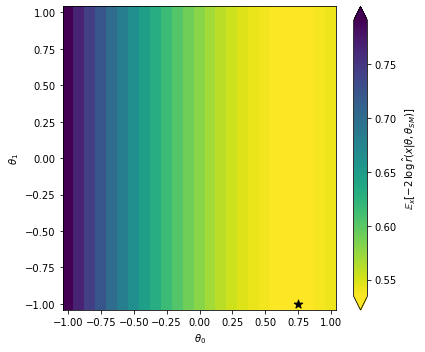

In [21]:
bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

expected_llr = np.mean(log_r_hat,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]

cmin, cmax = np.min(-2*expected_llr), np.max(-2*expected_llr)
    
pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((25,25)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$')

plt.tight_layout()
plt.show()


Note that in this tutorial our sample size was very small, and the network might not really have a chance to converge to the correct likelihood ratio function. So don't worry if you find a minimum that is not at the right point (the SM, i.e. the origin in this plot). Feel free to dial up the event numbers in the run card as well as the training samples and see what happens then!

In [ ]:
log_r_hat.shape

In [18]:
np.load('data/samples/x_train_ratio.npy').shape

(500000, 9)

In [26]:
theta = np.load('data/samples/theta0_train_ratio.npy')

In [28]:
theta.shape

(500000, 2)